# select train species data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from plantclef.config import get_device

print(f"PyTorch Version: {torch.__version__}")
device = get_device()
print(f"Using device: {device}")

PyTorch Version: 2.6.0+cu124
Using device: cuda


In [3]:
import pandas as pd
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path().resolve().parents[0]
print(root)
! date

/storage/home/hcoda1/9/mgustineli3/clef/pytorch-plantclef
Sun Mar 23 12:49:33 PM EDT 2025


### read dataframe

In [4]:
import json

# read grid dataframe
GRID_SIZE = 3
data_path = f"{root}/data/parquet/"
output_path = f"{data_path}/test_grid_{GRID_SIZE}x{GRID_SIZE}_embeddings"
grid_test_df = pd.read_parquet(output_path)
# Convert JSON strings back to Python dictionaries
grid_test_df["logits"] = grid_test_df["logits"].apply(json.loads)
grid_test_df.head(3)

,image_name,data,embeddings,logits,tile
0,CBN-PdlC-C4-20180723.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"[-1.3391107320785522, 1.6340396404266357, -2.2...","{'1741880': 0.1965922713279724, '1729043': 0.0...",0
1,LISAH-BOU-0-30-20230512.jpg,b'\xff\xd8\xff\xdb\x00C\x00\x06\x04\x05\x06\x0...,"[1.2548043727874756, 0.4113069772720337, -0.20...","{'1356012': 0.4993394911289215, '1356017': 0.0...",0
2,CBN-PdlC-C4-20140811.jpg,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,"[0.4095623195171356, 1.3787765502929688, -2.38...","{'1519650': 0.06178973615169525, '1392662': 0....",0


In [5]:
species_ids = grid_test_df["logits"].iloc[:9].to_list()
species_ids[:3]

[{'1741880': 0.1965922713279724,
  '1729043': 0.07081298530101776,
  '1392407': 0.025576600804924965,
  '1395758': 0.022835951298475266,
  '1391881': 0.022778529673814774},
 {'1356012': 0.4993394911289215,
  '1356017': 0.02324383147060871,
  '1358670': 0.016023512929677963,
  '1393251': 0.01263902522623539,
  '1662937': 0.011285717599093914},
 {'1519650': 0.06178973615169525,
  '1392662': 0.0420311838388443,
  '1622908': 0.04180571809411049,
  '1390821': 0.03379848971962929,
  '1502503': 0.025230366736650467}]

In [6]:
grid_test_df["logits"].iloc[:3]

0    {'1741880': 0.1965922713279724, '1729043': 0.0...
1    {'1356012': 0.4993394911289215, '1356017': 0.0...
2    {'1519650': 0.06178973615169525, '1392662': 0....
Name: logits, dtype: object

In [7]:
def extract_species_above_threshold(
    df, logits_col: str = "logits", threshold: float = 0.1
) -> list:
    """
    Extracts the first species ID and value from each row's logits dictionary,
    filtering only those above a given threshold.

    :param df: DataFrame containing logits column as dictionaries.
    :param logits_col: Name of the column containing logits dictionaries.
    :param threshold: Minimum value threshold for filtering.
    :return: List of species IDs that meet the threshold.
    """
    species_ids = []

    for logits in df[logits_col]:
        if isinstance(logits, dict) and logits:  # Ensure it's a valid dictionary
            first_key, first_value = next(
                iter(logits.items())
            )  # Get first key-value pair
            if first_value > threshold:
                species_ids.append(first_key)  # Store species ID if it meets threshold
    return species_ids

In [8]:
import numpy as np

thresholds = np.arange(0, 1, 0.1)
species_list = []
set_species = []
species_dict = {}
for thresh in thresholds:
    species_ids = extract_species_above_threshold(grid_test_df, threshold=thresh)
    species_dict[thresh] = species_ids

In [9]:
for key, val in species_dict.items():
    print(f"threshold: {round(key, 1)}, rows: {len(val)}, species:  {len(set(val))}")

threshold: 0.0, rows: 5400, species:  409
threshold: 0.1, rows: 3381, species:  257
threshold: 0.2, rows: 1935, species:  172
threshold: 0.3, rows: 1188, species:  115
threshold: 0.4, rows: 834, species:  84
threshold: 0.5, rows: 594, species:  60
threshold: 0.6, rows: 417, species:  43
threshold: 0.7, rows: 288, species:  27
threshold: 0.8, rows: 177, species:  14
threshold: 0.9, rows: 45, species:  5


In [10]:
# groupby species_id, get values
logits_dict = {}
for logits in grid_test_df["logits"]:
    if isinstance(logits, dict):  # Ensure it's a dictionary
        for key, val in logits.items():
            logits_dict.setdefault(key, []).append(val)


# compute mean and count per species
species_frequency = {
    key: {"mean": np.mean(vals), "count": len(vals)}
    for key, vals in logits_dict.items()
}


# sort species by count in descending order
def sort_nested_dict_descending(dict_of_dicts, key):
    return dict(
        sorted(dict_of_dicts.items(), key=lambda item: item[1][key], reverse=True)
    )


sorted_species_frequency = sort_nested_dict_descending(species_frequency, "count")

# extract frequencies for plotting
frequencies = {
    species: data["count"] for species, data in sorted_species_frequency.items()
}

In [11]:
# compute total count of logits
total_logits = sum(data["count"] for data in sorted_species_frequency.values())

# select species contributing to 90% of total logits
selected_species = []
cumulative_count = 0
THRESHOLD = 0.7
threshold_count = THRESHOLD * total_logits  # threshold % of total

for species, data in sorted_species_frequency.items():
    cumulative_count += data["count"]
    selected_species.append(species)
    if cumulative_count >= threshold_count:
        break  # stop when we reach threshold count

# show results
print(f"Total logits: {total_logits}")
print(f"Selected species count: {len(selected_species)}")
print("Selected species:", selected_species)

Total logits: 27000
Selected species count: 203
Selected species: ['1395807', '1361281', '1394311', '1741880', '1397468', '1392407', '1397535', '1390793', '1392323', '1722440', '1396869', '1412857', '1389929', '1395870', '1651363', '1519650', '1390899', '1391331', '1743474', '1394540', '1392558', '1390846', '1392608', '1742052', '1392611', '1392565', '1425722', '1722441', '1720959', '1396253', '1392535', '1362271', '1395990', '1741661', '1397475', '1722522', '1722625', '1393824', '1722521', '1397070', '1363302', '1391881', '1360591', '1397463', '1359344', '1394911', '1664563', '1390764', '1722433', '1362331', '1388766', '1361437', '1742053', '1359297', '1396843', '1393659', '1363200', '1394597', '1556096', '1393200', '1697384', '1361382', '1393679', '1357962', '1396857', '1396974', '1396717', '1394641', '1412585', '1451777', '1394663', '1397046', '1390874', '1622901', '1741624', '1390910', '1394908', '1360269', '1393770', '1393660', '1393927', '1397500', '1393657', '1396733', '1743968'

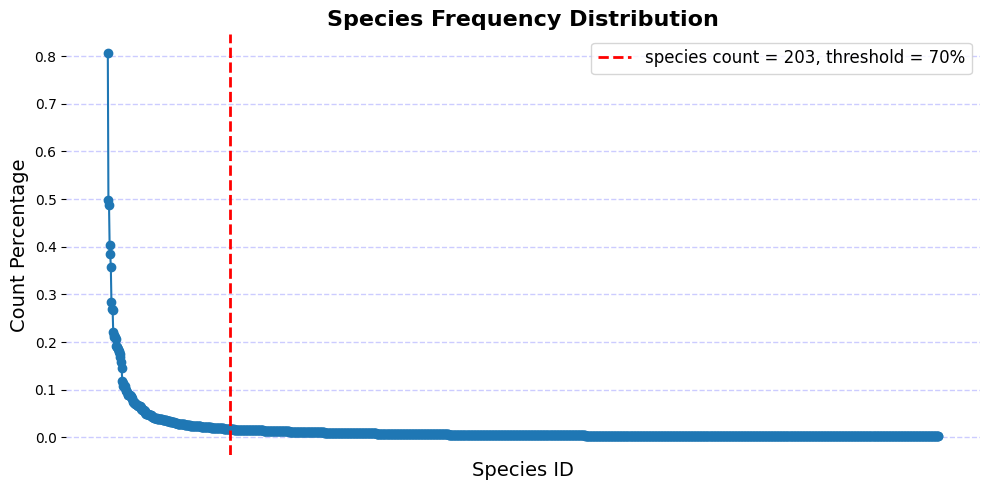

In [12]:
import matplotlib.pyplot as plt

# plot sorted species frequencies
species, count = zip(*frequencies.items())  # get species and their frequencies
species_dist = [c / len(species) for c in count]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(species, species_dist, marker="o")
species_count = len(selected_species)
label = f"species count = {species_count}, threshold = {THRESHOLD:.0%}"
ax.axvline(x=species_count, color="r", linestyle="--", linewidth=2, label=label)
ax.set_xlabel("Species ID", fontsize=12)
ax.set_ylabel("Count Percentage", fontsize=12)
ax.set_xticks([])
ax.set_title("Species Frequency Distribution", fontsize=16, weight="bold")
ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
ax.yaxis.label.set_size(14)  # Set the font size for the xlabel
ax.legend(fontsize=12)
ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
spines = ["top", "right", "bottom", "left"]
for s in spines:
    ax.spines[s].set_visible(False)
plt.tight_layout()
plt.show()

In [14]:
# write the selected species to a text file
with open("train_species_ids.txt", "w") as f:
    for species in selected_species:
        f.write(f"{species}\n")